<a href="https://colab.research.google.com/github/AaronMasterProg/Python/blob/main/Ejercicio_de_clasificaci%C3%B3n_de_im%C3%A1genes_de_flores_en_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
#Descargar set de datos de Flowers MNIST
import tensorflow_datasets as tfds
flowers, metadata = tfds.load('tf_flowers', as_supervised=True, with_info=True)

In [ ]:
#Imprimir los metadatos para ver que trae el set
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [ ]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento = flowers['train']

In [ ]:
#Etiquetas de las 10 categorias posibles
nombres_clases = metadata.features['label'].names

In [ ]:
nombres_clases

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
# Función de normalización
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255  # Normalizar de 0-255 a 0-1
  return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas con la función que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)

# Agregar cache para los datos de entrenamiento y pruebas (mejora la velocidad)
datos_entrenamiento = datos_entrenamiento.cache()

# Prefetch para optimizar la carga de datos en segundo plano
datos_entrenamiento = datos_entrenamiento.prefetch(tf.data.experimental.AUTOTUNE)


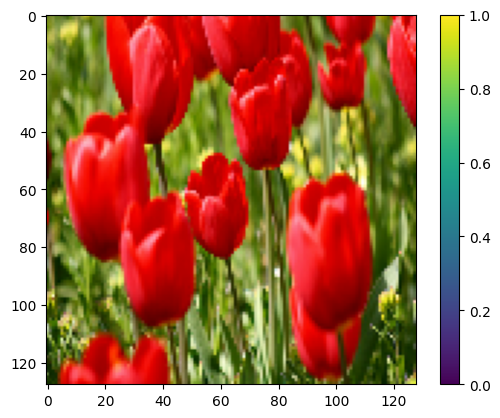

In [ ]:
import matplotlib.pyplot as plt

# Función de redimensionado
def redimensionar(imagen, etiqueta, nuevo_tamano=(128, 128)):
    imagen = tf.image.resize(imagen, nuevo_tamano)  # Redimensionar la imagen
    return imagen, etiqueta

# Aplicar redimensionado a los datos de entrenamiento ANTES del batch
#El error estaba en que se intentaba redimensionar despues del batch,
#por lo que ya no eran imagenes individuales si no un conjunto, por lo que ya no
#tenia la forma (alto, ancho, canales) si no (32, alto, ancho, canales) donde 32 es el tamaño del batch
datos_entrenamiento = flowers['train'].map(lambda imagen, etiqueta: redimensionar(imagen, etiqueta))

# Normalizar los datos de entrenamiento y pruebas con la función que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)

# Agregar cache para los datos de entrenamiento y pruebas (mejora la velocidad)
datos_entrenamiento = datos_entrenamiento.cache()

# Prefetch para optimizar la carga de datos en segundo plano
datos_entrenamiento = datos_entrenamiento.prefetch(tf.data.experimental.AUTOTUNE)

# Asegurarnos de que las imágenes sean de tamaño consistente en ambos conjuntos de datos
datos_entrenamiento = datos_entrenamiento.batch(32)  # Tamaño de lote

# Ahora podemos mostrar la primera imagen de los datos de entrenamiento
for imagen, etiqueta in datos_entrenamiento.take(1):
    break

# Convertir la imagen a un arreglo numpy y mostrarla
imagen = imagen.numpy()[0]  # Tomar la primera imagen del lote

# Dibujar la imagen
plt.figure()
plt.imshow(imagen)
plt.colorbar()
plt.grid(False)
plt.show()

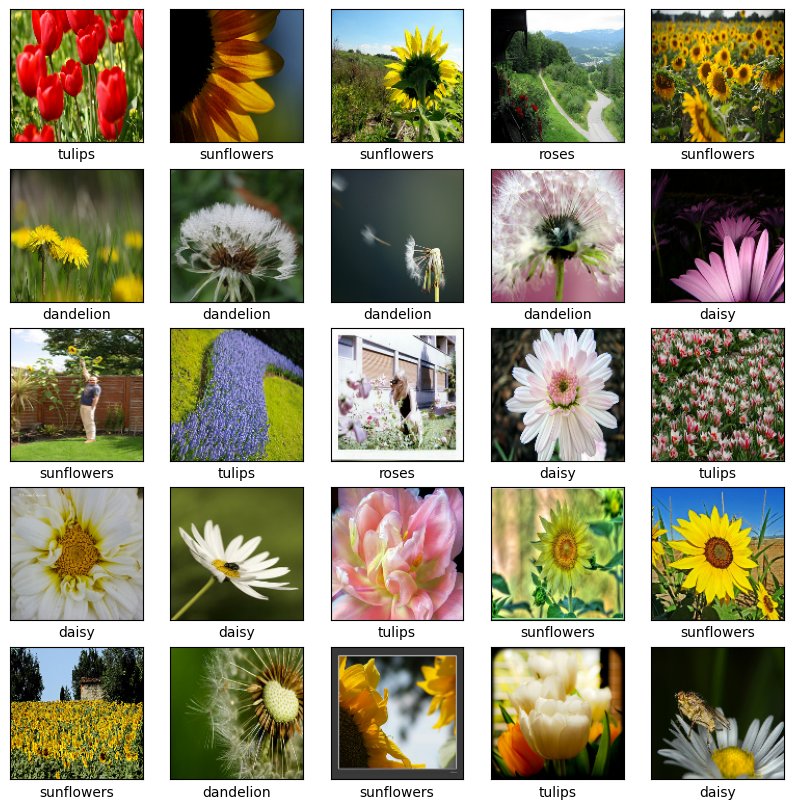

In [ ]:
import matplotlib.pyplot as plt

# Función de redimensionado
def redimensionar(imagen, etiqueta, nuevo_tamano=(128, 128)):
    imagen = tf.image.resize(imagen, nuevo_tamano)  # Redimensionar la imagen
    return imagen, etiqueta

# Aplicar redimensionado a los datos de entrenamiento ANTES del batch
datos_entrenamiento = flowers['train'].map(lambda imagen, etiqueta: redimensionar(imagen, etiqueta))

# Normalizar los datos de entrenamiento y pruebas con la función que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)

# Agregar cache para los datos de entrenamiento (mejora la velocidad)
datos_entrenamiento = datos_entrenamiento.cache()

# Prefetch para optimizar la carga de datos en segundo plano
datos_entrenamiento = datos_entrenamiento.prefetch(tf.data.experimental.AUTOTUNE)

# Asegurarnos de que las imágenes sean de tamaño consistente en ambos conjuntos de datos
datos_entrenamiento = datos_entrenamiento.batch(32)  # Tamaño de lote

# Crear la figura para mostrar las imágenes
plt.figure(figsize=(10, 10))

# Tomar 25 imágenes del primer lote (sólo 25 imágenes, no 25 lotes)
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(1)):
    for j in range(25):  # Solo tomamos las primeras 25 imágenes del lote
        plt.subplot(5, 5, j + 1)  # Crear una cuadrícula de 5x5
        plt.xticks([])  # Ocultar los ticks del eje X
        plt.yticks([])  # Ocultar los ticks del eje Y
        plt.grid(False)  # Desactivar la cuadrícula
        plt.imshow(imagen[j], cmap=plt.cm.binary)  # Mostrar la imagen
        plt.xlabel(nombres_clases[etiqueta[j]])  # Etiqueta debajo de la imagen

# Mostrar la cuadrícula de 25 imágenes
plt.show()


In [ ]:
# Crear el modelo para clasificar flores
modelo = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalización de las imágenes (RGB)
    tf.keras.layers.Flatten(),  # Aplanar las imágenes 2D a 1D
    tf.keras.layers.Dense(128, activation='relu'),  # Capa densa con activación ReLU
    tf.keras.layers.Dense(64, activation='relu'),   # Capa densa con activación ReLU
    tf.keras.layers.Dense(5, activation='softmax')   # 5 clases para flores, activación softmax para clasificación multiclase
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compilar el modelo
modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = metadata.splits["train"].num_examples

In [ ]:
print(num_ej_entrenamiento)

3670


In [ ]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import math

# Descargar el dataset de Flowers
flowers, metadata = tfds.load('tf_flowers', as_supervised=True, with_info=True)

# Obtener los datos de entrenamiento
datos_entrenamiento = flowers['train']

# Etiquetas de las 5 categorías posibles
nombres_clases = metadata.features['label'].names

# Función de redimensionado y normalización
def preprocess(imagen, etiqueta, nuevo_tamano=(224, 224)):
    # Redimensionar la imagen al tamaño esperado por el modelo
    imagen = tf.image.resize(imagen, nuevo_tamano)
    # Normalizar los píxeles de la imagen a valores entre 0 y 1
    imagen = tf.cast(imagen, tf.float32) / 255.0
    return imagen, etiqueta

# Aplicar la función de preprocesamiento
datos_entrenamiento = datos_entrenamiento.map(lambda img, lbl: preprocess(img, lbl))

# Agregar cache para mejorar la velocidad
datos_entrenamiento = datos_entrenamiento.cache()

# Prefetch para optimizar la carga de datos en segundo plano
datos_entrenamiento = datos_entrenamiento.prefetch(tf.data.experimental.AUTOTUNE)

# Número total de ejemplos en el dataset
num_ej_entrenamiento = metadata.splits["train"].num_examples

# Configurar lotes, mezclar y repetir
TAMANO_LOTE = 32
datos_entrenamiento = datos_entrenamiento.shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE).repeat()

# Crear el modelo para clasificar flores
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),  # Entrada con imágenes RGB redimensionadas
    tf.keras.layers.Dense(128, activation='relu'),       # Capa densa con 128 neuronas
    tf.keras.layers.Dense(64, activation='relu'),        # Capa densa con 64 neuronas
    tf.keras.layers.Dense(5, activation='softmax')       # Capa de salida para las 5 clases
])

# Compilar el modelo
modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Entrenar el modelo
historial = modelo.fit(
    datos_entrenamiento,
    epochs=5,
    steps_per_epoch=math.ceil(num_ej_entrenamiento / TAMANO_LOTE)
)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 68s 505ms/step - accuracy: 0.2959 - loss: 14.1630
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 409ms/step - accuracy: 0.3931 - loss: 3.8656
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 422ms/step - accuracy: 0.4276 - loss: 4.0305
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 416ms/step - accuracy: 0.4702 - loss: 1.8551
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 409ms/step - accuracy: 0.5324 - loss: 1.4417


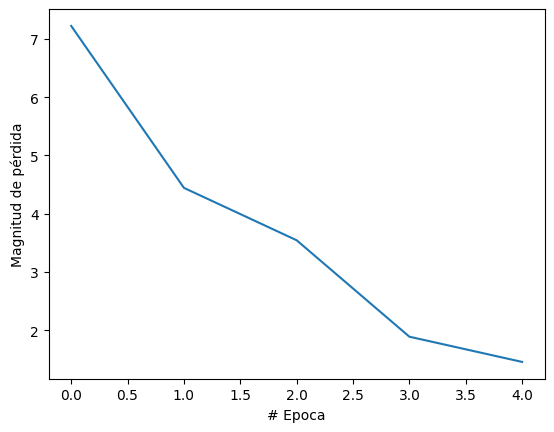

In [ ]:
import matplotlib.pyplot as plt

#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


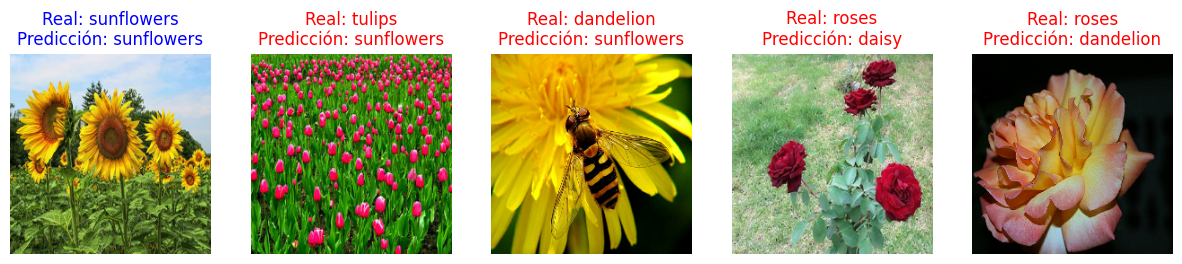

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Función para redimensionar y normalizar las imágenes
def procesar_imagen(imagen, etiqueta):
    imagen = tf.image.resize(imagen, [224, 224])  # Redimensionar a 224x224
    imagen = imagen / 255.0  # Normalizar
    return imagen, etiqueta

# Aplicar el procesamiento al conjunto de datos
datos_procesados = datos_entrenamiento.map(procesar_imagen)

# Crear lotes del conjunto de datos
TAMANO_LOTE = 32
datos_procesados = datos_procesados.batch(TAMANO_LOTE)

# Tomar un lote de datos procesados para hacer predicciones
for imagenes, etiquetas_reales in datos_procesados.shuffle(1000).take(1):
    imagenes = imagenes.numpy()  # Convertir a NumPy
    etiquetas_reales = etiquetas_reales.numpy()  # Convertir a NumPy
    predicciones = modelo.predict(imagenes)  # Realizar predicciones

# Función para mostrar una imagen y su predicción
def mostrar_imagen_con_prediccion(imagen, etiqueta_real, prediccion):
    etiqueta_prediccion = np.argmax(prediccion)  # Etiqueta predicha
    plt.imshow(imagen)
    plt.axis('off')
    color = "blue" if etiqueta_real == etiqueta_prediccion else "red"
    plt.title(f"Real: {nombres_clases[etiqueta_real]}\n"
              f"Predicción: {nombres_clases[etiqueta_prediccion]}",
              color=color)

# Mostrar 5 imágenes aleatorias del lote junto con predicciones
num_imagenes = 5  # Número de imágenes a mostrar
plt.figure(figsize=(15, 15))
for i in range(num_imagenes):
    plt.subplot(1, num_imagenes, i + 1)
    mostrar_imagen_con_prediccion(imagenes[i], etiquetas_reales[i], predicciones[i])
plt.show()


In [43]:
#Exportacion del modelo a h5
modelo.save('modelo_exportado.h5')

In [1]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

In [12]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir_flowersprueba
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir_flowersprueba

2025-01-14 20:42:10.688878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736887330.744864   24960 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736887330.762800   24960 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 20:42:10.827739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed

In [16]:
#Veamos si si creo la carpeta
!ls -l tfjs_target_dir_flowersprueba

total 75308
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard10of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard11of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard12of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard13of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard14of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard15of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard16of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard17of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard18of19.bin
-rw-r--r-- 1 root root 1607700 Jan 14 20:42 group1-shard19of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard1of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard2of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard3of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-shard4of19.bin
-rw-r--r-- 1 root root 4194304 Jan 14 20:42 group1-sha

In [17]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir_flowersprueba

group1-shard10of19.bin	group1-shard15of19.bin	group1-shard1of19.bin  group1-shard6of19.bin
group1-shard11of19.bin	group1-shard16of19.bin	group1-shard2of19.bin  group1-shard7of19.bin
group1-shard12of19.bin	group1-shard17of19.bin	group1-shard3of19.bin  group1-shard8of19.bin
group1-shard13of19.bin	group1-shard18of19.bin	group1-shard4of19.bin  group1-shard9of19.bin
group1-shard14of19.bin	group1-shard19of19.bin	group1-shard5of19.bin  model.json
